In [1]:
import os, sys, time, math
from natsort import natsorted, ns

import numpy as np
import cv2
import matplotlib.pyplot as plt
import cma
from PIL import Image
import glob
import re


from gvxrPython3 import gvxr
from gvxrPython3 import json2gvxr

from gvxrPython3.utils import visualise # Visualise the 3D environment if k3D is supported
from gvxrPython3.utils import plotScreenshot # Visualise the 3D environment using Matplotlib

from gvxrPython3.utils import loadSpekpySpectrum # Generate and load an X-ray spectrum using Spekpy
from gvxrPython3.utils import loadXpecgenSpectrum # Generate and load an X-ray spectrum using xpecgen

SimpleGVXR 2.0.6 (2023-05-23T20:52:16) [Compiler: Microsoft Visual Studio] on Windows
gVirtualXRay core library (gvxr) 2.0.6 (2023-05-23T20:53:11) [Compiler: Microsoft Visual Studio] on Windows


In [2]:
use_padding = True
pad_width = 50
angular_step_in_deg = 3.6

In [3]:
# data_path = "C:/Users/user/phd/Dataoff/"
# data_path = "C:/Users/user/phd/26SepImages/"
# data_path = "C:/Users/snn23kfl/project/"
#data_path = "4thOCtober_image/"
data_path = "4thCotober_imageAngle/"

In [4]:
current_folder = str(globals()['_dh'][0])
print(current_folder)

C:\Users\snn23kfl\project


In [5]:
def average_images(image_paths):
    
    """Average a list of images."""
  
    # Load the first image to get the shape
    sample_image = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
    if sample_image is None:
        raise ValueError(f"Failed to load image: {image_paths[0]}")
    
    avg_image = np.zeros_like(sample_image, dtype=float)
    
    if use_padding:
        avg_image = np.pad(avg_image, (pad_width, pad_width), mode='median')

    for path in image_paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            raise ValueError(f"Failed to load image: {path}")

        if use_padding:
            median_value = np.median(image)
            image = np.pad(image, (pad_width, pad_width), 'constant', constant_values=(median_value, median_value))

        avg_image += image.astype(float)
    
    avg_image /= len(image_paths)
    
    return cv2.medianBlur(avg_image.astype(np.single), 3)

In [6]:
def flatField(img, white, dark, epsilon=0.0):

    temp_white = np.copy(white)
    temp_img = np.copy(img)
    
    test = white - dark == 0
    temp_white[test] += 1

    if len(img.shape) == 2:
        temp_img[test] += 1
        return (temp_img - dark + epsilon) / (temp_white - dark + epsilon)
    elif len(img.shape) == 3:
        flat = np.zeros(img.shape, dtype=np.single)
        for i, proj in enumerate(temp_img):
            proj[test] += 1
            flat[i] = (proj - dark + epsilon) / (temp_white - dark + epsilon)
        return flat
    else:
        raise IOError("Bad image dimension: " + str(img.shape))

In [7]:
#path for my recently acquired images stored in PhD file



dark_field_paths = glob.glob(data_path + '/darkfd/darkfd_*.tiff')
dark_field_paths = natsorted(dark_field_paths, key=lambda y: y.lower())

white_field_paths = glob.glob(data_path + '/whitefd/whitefd_*.tiff')
white_field_paths = natsorted(white_field_paths, key=lambda y: y.lower())

raw_image_paths = glob.glob(data_path + '/raw_images/raw_image_*.tiff')
raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

if len(raw_image_paths) == 0:
    raw_image_paths = glob.glob(data_path + '/rawimages/raw_images_*.jpg')
    raw_image_paths = natsorted(raw_image_paths, key=lambda y: y.lower())

In [8]:
#Average the dark field and white field images
I_dark = average_images(dark_field_paths)
I_white = average_images(white_field_paths)

In [9]:
I_raw = []
angles_in_deg = []
for i, fname in enumerate(raw_image_paths):

    angle = angular_step_in_deg * i

    if angle < 360.000001:
        angles_in_deg.append(angular_step_in_deg * i)
        I_raw.append(cv2.imread(fname, 
                               cv2.IMREAD_GRAYSCALE))
    
        if use_padding:
            median_value = np.median(I_raw[-1])
            I_raw[-1] = np.pad(I_raw[-1], (pad_width, pad_width), 'constant', constant_values=(median_value, median_value))

I_raw = np.array(I_raw, dtype=np.single)
# I_raw = average_images(raw_image_paths)

# for image in I_raw:
#     image /= np.mean(image[:,0:200])

# I_white /= np.mean(I_white[:,0:200])
# I_dark /= np.mean(I_dark[:,0:200])

I_flat1 = flatField(I_raw, I_white, I_dark)
I_flat2 = flatField(I_raw, I_white, np.zeros(I_dark.shape))

# Clamp pixel values
I_flat1[I_flat1<0] = 0
I_flat2[I_flat2<0] = 0

I_flat1[I_flat1>1] = 1
I_flat2[I_flat2>1] = 1

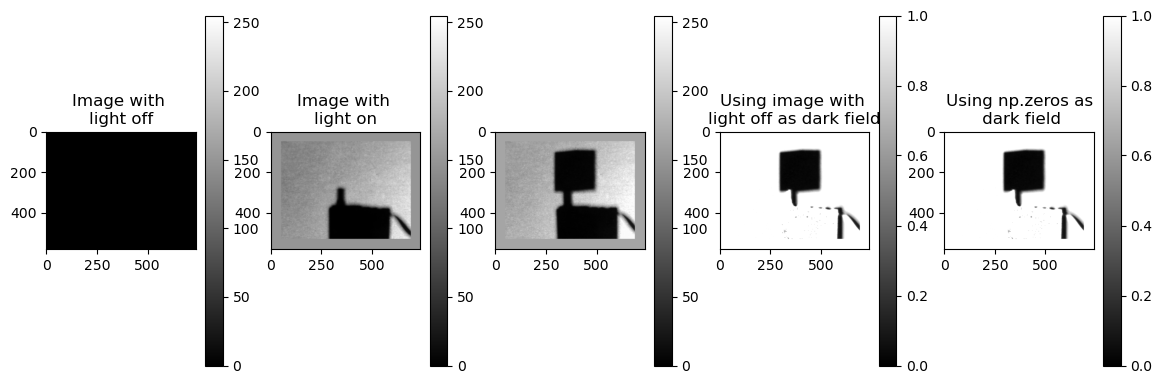

In [10]:
plt.figure(figsize=(14,10))
plt.subplot(2, 5, 1)
plt.title("Image with \nlight off")
plt.imshow(I_dark, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

plt.subplot(2, 5, 2)
plt.title("Image with \nlight on")
plt.imshow(I_white, cmap="gray", vmin=0, vmax=255)
plt.colorbar()

if len(I_raw.shape) == 2:

    plt.subplot(2, 5, 3)
    plt.imshow(I_raw, cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.imshow(I_flat1, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    
    plt.subplot(2, 5, 5)
    plt.imshow(I_flat2, cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
else:
    plt.subplot(2, 5, 3)
    plt.imshow(I_raw[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=255)
    plt.colorbar()

    plt.subplot(2, 5, 4)
    plt.title("Using image with \nlight off as dark field")
    plt.imshow(I_flat1[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()

    plt.subplot(2, 5, 5)
    plt.title("Using np.zeros as\n dark field")
    plt.imshow(I_flat2[I_raw.shape[0] //2], cmap="gray", vmin=0, vmax=1)
    plt.colorbar()


In [11]:
I_flat = I_flat2

In [12]:
##sod = 43
##sod =47
#sod = 48
#sdd = 61
sod=121
sdd=142

In [13]:
Ti90Al10 = 5.68
x_src = 0
y_src = 0
z_src = sod

x_det = 0
y_det = 0
z_det = -(sdd - sod)

x_obj1 = 5
y_obj1 = 0
z_obj1 = 0

x_obj2 = 5
y_obj2 = 0
z_obj2 = 0

alpha_x = 0 
alpha_y = 0
alpha_z = 0

x_rot = 0
y_rot = 0
z_rot = 0

x_default = [
    x_src,
    y_src,
    z_src,

    x_det,
    y_det,
    z_det,

    x_obj1,
    y_obj1,
    z_obj1,

    alpha_x, 
    alpha_y,
    alpha_z,

    x_obj2,
    y_obj2,
    z_obj2,

#     x_rot,
#     y_rot,
#     z_rot,
]


In [14]:
def printX(x):
    print("source-detector distance:", math.sqrt(math.pow(x_src - x_det, 2) + math.pow(y_src - y_det, 2) + math.pow(z_src - z_det, 2)), "mm")
    print("Source position:", x_src, y_src, z_src, "mm")
    print("Detector position:", x_det, y_det, z_det, "mm")
    # SDD?
    # SOD?

In [15]:
# Initialise gVXR using our JSON file
json2gvxr.initGVXR(current_folder + "/simulation1.json", "OPENGL", 3, 2)

Create an OpenGL context: 512x512


In [16]:
# Load our source properties
json2gvxr.initSourceGeometry()
json2gvxr.initSpectrum(verbose=0)

gvxr.setSourcePosition(x_src, y_src, z_src, "mm")

Set up the beam
	Source position: [0.0, 0.0, 0.0, 'mm']
	Source shape: PointSource


In [17]:
def getAverageEnergy(k, f):
    
    avg = 0
    for energy, count in zip(k, f):
        avg += energy * count
        
    return avg / np.sum(f)

In [18]:
# Load our detector
json2gvxr.initDetector()
    # "NumberOfPixels": [2880, 2880],

gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

if use_padding:
    number_of_pixels = gvxr.getDetectorNumberOfPixels();
    gvxr.setDetectorNumberOfPixels(number_of_pixels[0] + 2 * pad_width, number_of_pixels[1] + 2 * pad_width);

Set up the detector
	Detector position: [0.0, 0.0, 0.0, 'mm']
	Detector up vector: [0, -1, 0]
	Number of pixels: [640, 480]
	Detector number of pixels: [640, 480]
	Pixel spacing: [0.23, 0.23, 'mm']


In [19]:
# Load our samples
json2gvxr.initSamples(verbose=0)

gvxr.setDensity("cuboid", Ti90Al10, "g/cm3")

In [20]:
# ID = "cuboid"
# gvxr.rotateNode(ID, 90, 1.0, 0.0, 0.0)
# gvxr.moveToCentre()
# gvxr. applyCurrentLocalTransformation(ID)

# alpha_x = 0
# alpha_y = 0
# alpha_z = 0

# x_obj = 0
# y_obj = 0
# z_obj = 0

In [21]:
visualise()

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

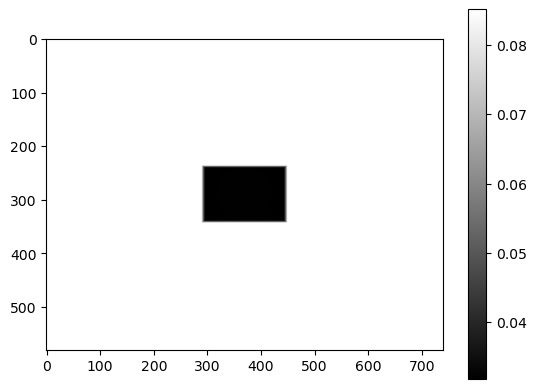

In [22]:
# Let's get an x-ray image
fig = plt.figure()
plt.imshow(gvxr.computeXRayImage(), cmap="gray")
plt.colorbar()
plt.show()

In [23]:
def getReference(I_flat, angles_in_deg, number_of_angles):

    images = []
    angles = []
    
    for i in range(number_of_angles):

        if number_of_angles == 1:
            index = 0
        else:
            index = round((i + 1) / number_of_angles * (len(angles_in_deg) // 4))
        
        images.append(I_flat[index])
        angles.append(angles_in_deg[index])

    return np.array(images), np.array(angles)

In [24]:
ref_image, selected_angles = getReference(I_flat, angles_in_deg, 1)

In [25]:
def getXrayImage(x, take_screenshot=False):

    global screenshot
    screenshot = []

    backup = gvxr.getLocalTransformationMatrix("root")

    # Move source, det, object using x
    x_src = x[0]
    y_src = x[1]
    z_src = x[2]
    gvxr.setSourcePosition(x_src, y_src, z_src, "mm")
    
    x_det = x[3]
    y_det = x[4]
    z_det = x[5]
    gvxr.setDetectorPosition(x_det, y_det, z_det, "mm")

    x_obj1 = x[6]
    y_obj1 = x[7]
    z_obj1 = x[8]

    alpha_x = x[9]
    alpha_y = x[10]
    alpha_z = x[11]

    x_obj2 = x[12]
    y_obj2 = x[13]
    z_obj2 = x[14]

    test_image = []

    up_vector = gvxr.getDetectorUpVector();
    
    for rot_angle in selected_angles:
        gvxr.resetSceneTransformation();
    
        
        
        
    #     gvxr.translateNode("root", x_rot_axis_pos, y_rot_axis_pos, z_rot_axis_pos, "mm")
    
        
        gvxr.rotateNode("root", rot_angle, up_vector[0], up_vector[1], up_vector[2])
        
        gvxr.translateNode("root", x_obj1, y_obj1, z_obj1, "mm")
        
        gvxr.rotateNode("root", alpha_x, 1, 0, 0)
        gvxr.rotateNode("root", alpha_y, 0, 1, 0)
        gvxr.rotateNode("root", alpha_z, 0, 0, 1)
        
        gvxr.translateNode("root", -x_obj2, -y_obj2, -z_obj2, "mm")
        
        test_image.append(gvxr.computeXRayImage())
    
        if take_screenshot:

            gvxr.displayScene()        
            screenshot.append(gvxr.takeScreenshot())
        
        gvxr.setLocalTransformationMatrix("root", backup)

        
    
    return np.array(test_image, dtype=np.single) / gvxr.getTotalEnergyWithDetectorResponse()

In [26]:
def compareMAE(ref, test):
    return np.abs(ref - test).mean()

def compareMSE(ref, test):
    return np.square(ref - test).mean()


def fitnessMAE(x):
    global ref_image

    test_image = getXrayImage(x)
    fitness_value = compareMAE(ref_image, test_image)
        
    return fitness_value

def fitnessMSE(x):
    global ref_image

    test_image = getXrayImage(x)
    fitness_value = compareMSE(ref_image, test_image)
        
    return fitness_value

In [27]:
def displayResult(x, figsize=(15, 4)):
    global screenshot
    test_image = getXrayImage(x, True)
    
    ref_tmp = np.copy(ref_image)
    test_tmp = np.copy(test_image)
    
    ref_tmp -= ref_tmp.mean()
    ref_tmp /= ref_tmp.std()

    test_tmp -= test_tmp.mean()
    test_tmp /= test_tmp.std()

    ZNCC = 100 * (ref_tmp / test_tmp).mean()
    
    #fig, axs = plt.subplots(len(screenshot), 4, figsize=figsize)
    fig, axs = plt.subplots(len(screenshot), 4, figsize=figsize, squeeze=False)
    plt.suptitle("Overall ZNCC=" + "{:.4f}".format(ZNCC) + "%")

    for index in range(len(screenshot)):
#         axs[index][0].imshow(screenshot[index])
#         axs[index][1].imshow(ref_image[index], cmap="gray", vmin=0, vmax=1)
#     #   axs[1].imshow(I_flat,cmap="gray", vmin=0, vmax=1)
#         axs[index][2].imshow(test_image[index],cmap="gray", vmin=0, vmax=1)
#         im = axs[index][3].imshow((ref_image[index] - test_image[index]),cmap="gray", vmin=-1, vmax=1)
#         axs[index][0].set_title("Rotation angle: " + str(selected_angles[index]) + "$^\circ$")
        axs[index][0].imshow(screenshot[index])
        axs[index][1].imshow(ref_image[index], cmap="gray", vmin=0, vmax=1)
        axs[index][2].imshow(test_image[index], cmap="gray", vmin=0, vmax=1)
        im = axs[index][3].imshow((ref_image[index] - test_image[index]), cmap="gray", vmin=-1, vmax=1)
        axs[index][0].set_title("Rotation angle: " + str(selected_angles[index]) + "$^\circ$")


#    im = axs[3].imshow((I_flat - test_image),cmap="gray", vmin=-1, vmax=1)
    # cbar = fig.colorbar(im)

#     for ax in axs:
#         ax.set_xlim([100, 600])
#         ax.set_ylim([211, 470])
#    plt.savefig('x_default.jpg', dpi=300, bbox_inches='tight')

    plt.show()    

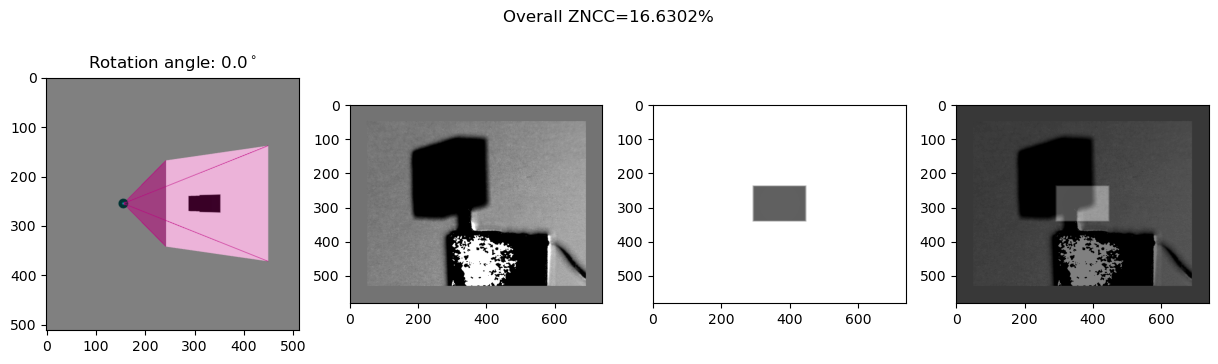

In [28]:
# %matplotlib notebook

displayResult(x_default)

In [29]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-5;
opts['bounds'] = [np.hstack((12*[-1000], [-180, -180])), np.hstack((12*[1000], [180, 180]))];

fname = current_folder + "/" + data_path + "/x_best1.dat"
if not os.path.exists(fname):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_default, 0.5, opts);
    es.optimize(fitnessMAE);
    elapsed_time = time.time() - start_time

    x_best1 = es.result.xbest
    np.savetxt(fname, x_best1)
else:
    x_best1 = np.loadtxt(fname)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=976192, Sat Oct 21 02:04:56 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 5.551121830940247e-01 1.0e+00 4.64e-01  5e-01  5e-01 0:00.4
    2     24 5.547356009483337e-01 1.1e+00 4.52e-01  4e-01  5e-01 0:00.8
    3     36 5.541224479675293e-01 1.1e+00 4.61e-01  4e-01  5e-01 0:01.2
   12    144 5.455884933471680e-01 1.7e+00 1.21e+00  1e+00  1e+00 0:04.6
   23    276 4.631001353263855e-01 2.0e+00 6.17e+00  6e+00  7e+00 0:08.7
   33    396 3.971748948097229e-01 2.3e+00 1.21e+01  1e+01  1e+01 0:14.0
   44    528 2.855551242828369e-01 2.8e+00 8.26e+00  7e+00  1e+01 0:20.1
   57    684 3.416100144386292e-01 3.7e+00 1.04e+01  8e+00  1e+01 0:27.2
   72    864 2.535763978958130e-01 4.6e+00 9.29e+00  7e+00  1e+01 0:35.3
   89   1068 2.054288089275360e-01 5.9e+00 6.31e+00  5e+00  8e+00 0:44.7
  100   1200 1.793513745069504e-01 6.7e+00 4.31e+00  3e+00  5e+00 0:50.7
  120   1440 1.734570115804672e-0

In [30]:
print(x_best1)

[ 184.37575998  -45.05184326  379.3195593    36.69580092 -605.86496617
 -693.80936529  -15.27517506 -125.69668557  203.98178899  -39.71391011
   19.90026977  -38.62192112 -107.36979302   66.92859763  -95.03868532]


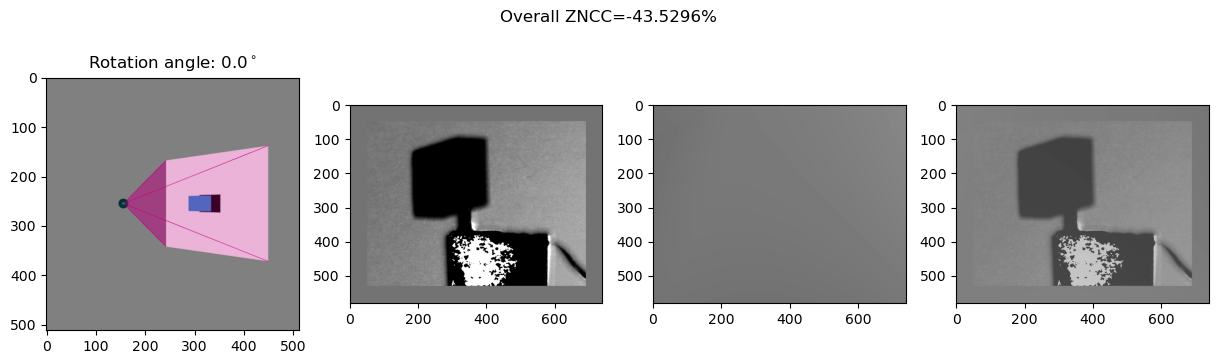

In [31]:
displayResult(x_best1)

In [32]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-5;
opts['bounds'] = [np.hstack((12*[-1250], [-180, -180])), np.hstack((12*[1250], [180, 180]))];

fname = current_folder + "/" + data_path + "/x_best2.dat"
if not os.path.exists(fname):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_best1, 0.25, opts);
    es.optimize(fitnessMSE);
    elapsed_time = time.time() - start_time

    x_best2 = es.result.xbest
    np.savetxt(fname, x_best2)
else:
    x_best2 = np.loadtxt(fname)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=920994, Sat Oct 21 02:10:26 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 5.553884804248810e-02 1.0e+00 2.34e-01  2e-01  2e-01 0:00.6
    2     24 5.518608912825584e-02 1.1e+00 2.21e-01  2e-01  2e-01 0:01.2
    3     36 5.500394105911255e-02 1.2e+00 2.25e-01  2e-01  2e-01 0:01.8
    9    108 5.412285774946213e-02 1.7e+00 3.17e-01  3e-01  3e-01 0:05.3
   16    192 5.368122085928917e-02 2.1e+00 3.81e-01  3e-01  4e-01 0:09.5
   25    300 5.363211035728455e-02 2.5e+00 3.14e-01  2e-01  4e-01 0:14.8
   36    432 5.358294397592545e-02 2.9e+00 2.18e-01  2e-01  2e-01 0:21.3
   48    576 5.350052937865257e-02 3.9e+00 1.98e-01  1e-01  2e-01 0:28.3
   62    744 5.332474783062935e-02 5.6e+00 1.84e-01  1e-01  2e-01 0:36.7
   78    936 5.303815752267838e-02 1.2e+01 3.53e-01  2e-01  6e-01 0:46.2
   95   1140 5.251860246062279e-02 2.2e+01 5.41e-01  3e-01  1e+00 0:56.3
  100   1200 5.247188732028008e-0

In [33]:
print(x_best2)

[ 175.70652488  -45.23530863  372.56740093   33.25025229 -611.0658353
 -691.32121766  -19.78458912 -114.7546435   213.20334392  -31.2555949
   18.92134889  -14.86301493 -118.34874935   67.11677999 -104.18766997]


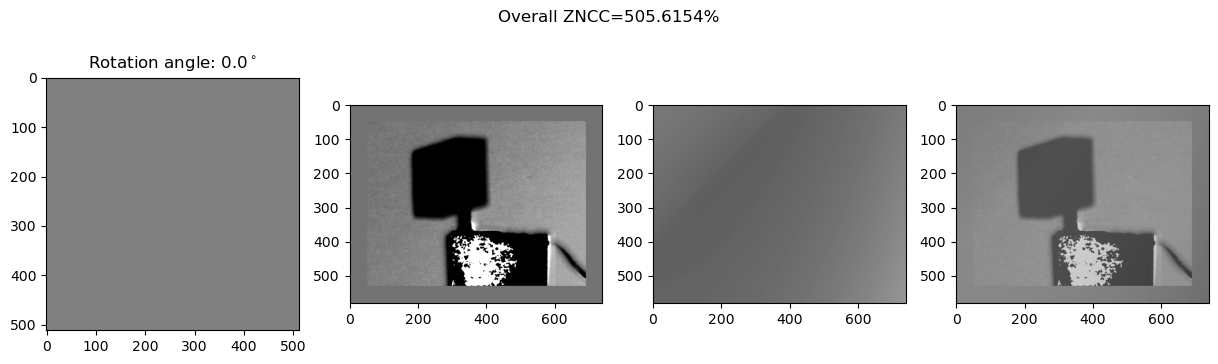

In [34]:
displayResult(x_best2)

In [35]:
ref_image, selected_angles = getReference(I_flat, angles_in_deg, 2)

In [36]:
def displayRef(ref_image):


    for i in range(ref_image.shape[0]): 
        plt.figure(figsize=(5,5))
        # ax = plt.subplot(1, ref_image.shape[i], i+1)
        plt.title("Angle: " + str(selected_angles[i]))
        plt.imshow(ref_image[i], cmap="gray", vmin=0, vmax=1)

    plt.show()

In [37]:
opts = cma.CMAOptions()
opts.set('tolfun', 1e-5);
opts['tolx'] = 1e-5;
opts['bounds'] = [np.hstack((12*[-1000], [-180, -180])), np.hstack((12*[1000], [180, 180]))];

fname = current_folder + "/" + data_path + "/x_best3.dat"
if not os.path.exists(fname):
    start_time = time.time();
    es = cma.CMAEvolutionStrategy(x_default, 0.5, opts);
    es.optimize(fitnessMSE);
    elapsed_time = time.time() - start_time

    x_best3 = es.result.xbest
    np.savetxt(fname, x_best3)
else:
    x_best3 = np.loadtxt(fname)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 15 (seed=866513, Sat Oct 21 02:13:17 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 1.266586035490036e-01 1.0e+00 4.49e-01  4e-01  5e-01 0:01.3
    2     24 1.253514736890793e-01 1.1e+00 4.43e-01  4e-01  5e-01 0:02.6
    3     36 1.243402883410454e-01 1.1e+00 4.59e-01  4e-01  5e-01 0:03.8
    6     72 1.215832382440567e-01 1.4e+00 5.75e-01  5e-01  7e-01 0:07.6
   10    120 1.155144274234772e-01 1.8e+00 8.52e-01  8e-01  1e+00 0:12.5
   15    180 1.081308871507645e-01 1.8e+00 1.76e+00  2e+00  2e+00 0:18.6
   20    240 9.396255016326904e-02 1.7e+00 3.97e+00  4e+00  5e+00 0:24.7
   26    312 7.915742695331573e-02 1.7e+00 5.31e+00  5e+00  6e+00 0:32.1
   33    396 6.874802708625793e-02 1.8e+00 5.51e+00  5e+00  6e+00 0:40.8
   41    492 6.560250371694565e-02 1.9e+00 5.45e+00  5e+00  6e+00 0:50.7
   50    600 7.323408871889114e-02 2.3e+00 5.18e+00  4e+00  6e+00 1:01.9
   59    708 6.459435075521469e-0

In [38]:
print(x_best3)

[-185.96319903   11.20825242  778.49762623  493.39861644   -9.49696906
 -952.11434241   14.14448049 -158.37063935   36.83003412  -12.24199095
   43.26797258  -15.91747878  -85.09858768 -167.66493683  -36.21127317]


In [39]:
simulated_xray_images = getXrayImage(x_best3)

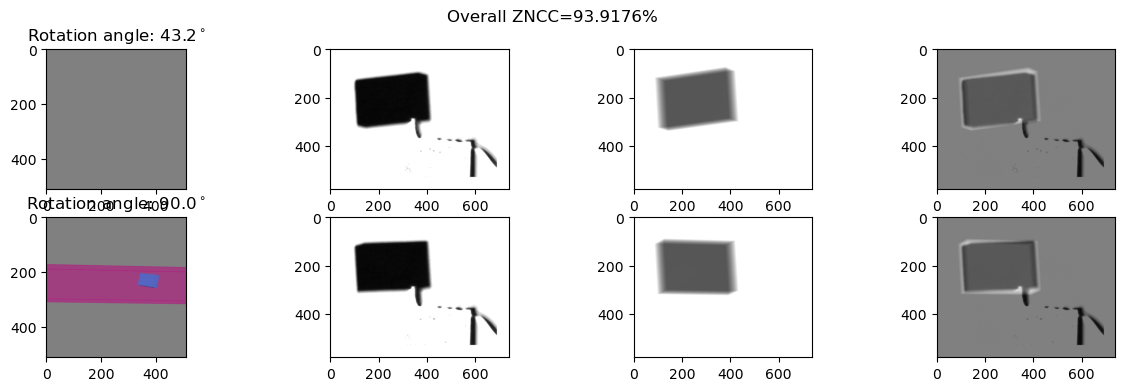

In [40]:
displayResult(x_best3)

In [41]:
# ref_image, selected_angles = getReference(I_flat, angles_in_deg, len(angles_in_deg))
ref_image, selected_angles = getReference(I_flat, angles_in_deg, 5)

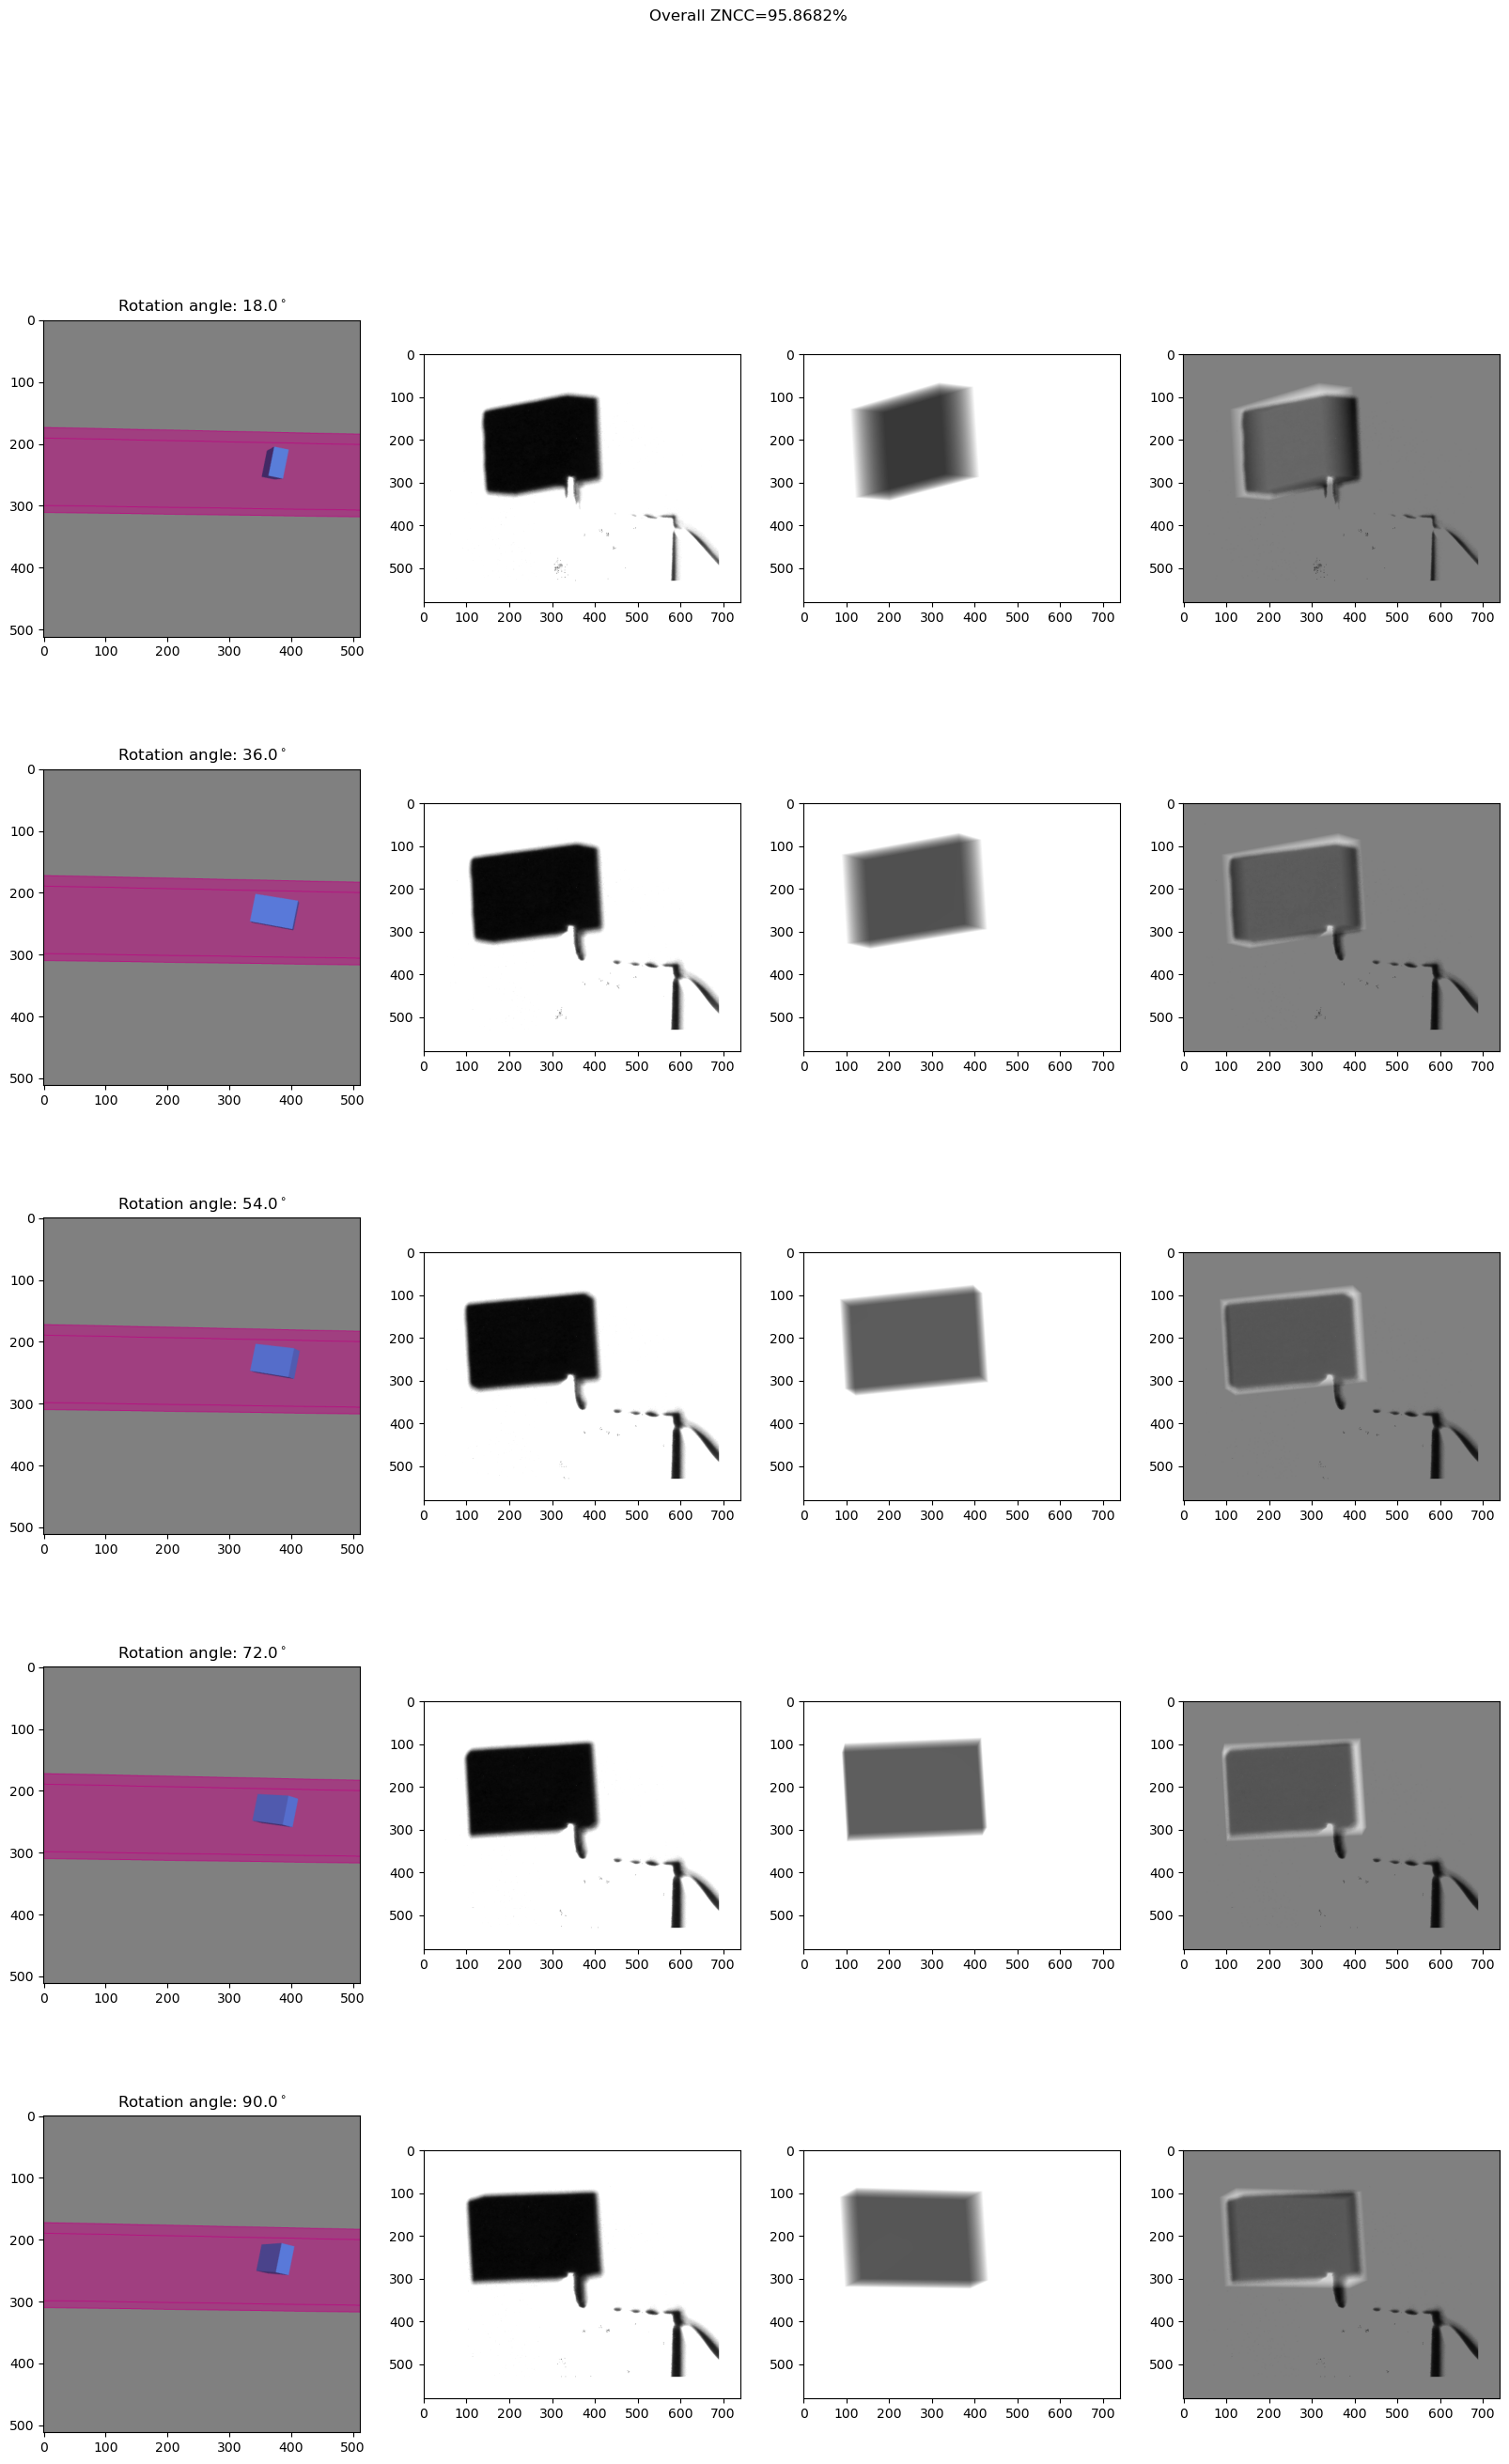

In [42]:
displayResult(x_best3, figsize=(20,30))

In [43]:
printX(x_best3)

source-detector distance: 142.0 mm
Source position: 0 0 121 mm
Detector position: 0 0 -21 mm
